In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
from requests.auth import HTTPBasicAuth
import time
%matplotlib inline

In [2]:
NUM_ITERATIONS = 10
def avg(l):
    return float(sum(l))/(len(l))

In [68]:
query0_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX brick: <http://buildsys.org/ontologies/Brick#> 
PREFIX bf: <http://buildsys.org/ontologies/BrickFrame#> 
SELECT DISTINCT ?vav
WHERE {
    ?vav rdf:type brick:VAV .
}
"""

query0_hod = """
SELECT ?vav
WHERE {
    ?vav rdf:type brick:VAV .
};
"""

query0_rdf3x = query0_sparql

query1_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX brick: <http://buildsys.org/ontologies/Brick#> 
PREFIX bf: <http://buildsys.org/ontologies/BrickFrame#> 
SELECT DISTINCT ?sensor ?room
WHERE {

    ?sensor rdf:type/rdfs:subClassOf* brick:Zone_Temperature_Sensor .
    ?room rdf:type brick:Room .
    ?vav rdf:type brick:VAV .
    ?zone rdf:type brick:HVAC_Zone .

    ?vav bf:feeds+ ?zone .
    ?zone bf:hasPart ?room .

    {?sensor bf:isPointOf ?vav }
    UNION
    {?sensor bf:isPointOf ?room }
}
"""
query1_hod = """
SELECT ?sensor ?room
WHERE {
    ?sensor rdf:type/rdfs:subClassOf* brick:Zone_Temperature_Sensor .
    ?room rdf:type brick:Room .
    ?vav rdf:type brick:VAV .
    ?zone rdf:type brick:HVAC_Zone .

    ?vav bf:feeds+ ?zone .
    ?zone bf:hasPart ?room .

    { ?sensor bf:isPointOf ?vav .
    OR
    ?sensor bf:isPointOf ?room . }
};
"""
query1_rdf3x = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX brick: <http://buildsys.org/ontologies/Brick#> 
PREFIX bf: <http://buildsys.org/ontologies/BrickFrame#> 
SELECT DISTINCT ?sensor ?room
WHERE {
     ?sensor rdf:type brick:ZoneTemperatureSensor .
     ?room rdf:type brick:Room .
     ?vav rdf:type brick:VAV .
     ?zone rdf:type brick:HVACZone .
     ?vav bf:feeds ?zone .
     ?zone bf:hasPart ?room .
     ?vav bf:hasPoint ?sensor .
}
"""

query1_hod_3x = """
SELECT ?sensor ?room
WHERE {
    ?sensor rdf:type/rdfs:subClassOf* brick:Zone_Temperature_Sensor .
    ?room rdf:type brick:Room .
    ?vav rdf:type brick:VAV .
    ?zone rdf:type brick:HVAC_Zone .
    ?vav bf:feeds+ ?zone .
    ?zone bf:hasPart ?room .
    ?vav bf:hasPoint ?sensor .
};
"""

query2_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX brick: <http://buildsys.org/ontologies/Brick#> 
PREFIX bf: <http://buildsys.org/ontologies/BrickFrame#> 
SELECT ?vlv_cmd ?vav
WHERE {
    {
      { ?vlv_cmd rdf:type brick:Reheat_Valve_Command }
      UNION
      { ?vlv_cmd rdf:type brick:Cooling_Valve_Command }
    }
    ?vav rdf:type brick:VAV .
    ?vav bf:hasPoint+ ?vlv_cmd .
}
"""
query2_hod = """
SELECT ?vlv_cmd ?vav
WHERE {
    {
      { 
      ?vlv_cmd rdf:type brick:Reheat_Valve_Command .
      OR
      ?vlv_cmd rdf:type brick:Cooling_Valve_Command .
      }
    }
    ?vav rdf:type brick:VAV .
    ?vav bf:hasPoint+ ?vlv_cmd .
};
"""
query2_rdf3x = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX brick: <http://buildsys.org/ontologies/Brick#> 
PREFIX bf: <http://buildsys.org/ontologies/BrickFrame#> 
SELECT ?vlvcmd ?vav
WHERE {
    ?vlvcmd rdf:type brick:ReheatValveCommand .
      #UNION
      #{ ?vlvcmd rdf:type brick:CoolingValveCommand }
    ?vav rdf:type brick:VAV .
    ?vav bf:hasPoint ?vlvcmd .
}
"""

query3_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX brick: <http://buildsys.org/ontologies/Brick#> 
PREFIX bf: <http://buildsys.org/ontologies/BrickFrame#> 
SELECT ?floor ?room ?zone
WHERE {
    ?floor rdf:type brick:Floor .
    ?room rdf:type brick:Room .
    ?zone rdf:type brick:HVAC_Zone .

    ?room bf:isPartOf+ ?floor .
    ?room bf:isPartOf+ ?zone .
}
"""
query3_hod = """
SELECT ?floor ?room ?zone
WHERE {
    ?floor rdf:type brick:Floor .
    ?room rdf:type brick:Room .
    ?zone rdf:type brick:HVAC_Zone .

    ?room bf:isPartOf+ ?floor .
    ?room bf:isPartOf+ ?zone .
};
"""
query3_rdf3x = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX brick: <http://buildsys.org/ontologies/Brick#> 
PREFIX bf: <http://buildsys.org/ontologies/BrickFrame#> 
SELECT ?floor ?room ?zone
WHERE {
    ?floor rdf:type brick:Floor .
    ?room rdf:type brick:Room .
    ?zone rdf:type brick:HVACZone .
    ?room bf:isPartOf ?floor .
    ?zone bf:hasPart ?room .
}
"""

In [4]:
# runs function for some iterations and prints average
def run(func, show_first=False, iterations=NUM_ITERATIONS):
    query_times = []
    for i in range(iterations):
        t1 = time.time()*1000
        resp = func()
        t2 = time.time()*1000
        if resp is None: break
        if i == 0 and show_first: print resp.content
        query_times.append(t2-t1)
        print i, '{0:.2f}'.format(t2-t1)
        time.sleep(.5)
    query_avg = avg(query_times)
    print "Took {0:.2f}ms".format(query_avg)

In [38]:
def get_runs(func, iterations=NUM_ITERATIONS):
    runs = []
    for i in range(iterations):
        t1 = time.time()*1000
        resp = func()
        t2 = time.time()*1000
        if resp is None: break
        runs.append(t2-t1)
        time.sleep(0.5)
    return runs

## Hod Benchmark

In [112]:
# Hod Configs
HOD_SERVER = "http://localhost:47808/query"

In [113]:
# run hod
!cd hod; ./runserver.sh ; cd ..
#!cd hod; docker kill hod ; docker rm hod; docker run -d --name hod -p47808:47808 gtfierro/hod

+ docker pull gtfierro/hod
Using default tag: latest
latest: Pulling from gtfierro/hod
Digest: sha256:d3cbaf3d37f868b35d7f6fecb553b154957c815e2bc79883cdbb2aabd1bfb98c
Status: Image is up to date for gtfierro/hod:latest
+ docker kill hod
Error response from daemon: Cannot kill container hod: No such container: hod
+ docker rm hod
Error response from daemon: No such container: hod
+ docker run -d --name hod -p47808:47808 gtfierro/hod
6b4259c638d0675ed33e21bd36718db2051cb48afabb41d1e8214c415dc278c9


In [69]:
## query 0
def hod_query_0():
    resp = requests.post(HOD_SERVER, data=query0_hod)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
## query 1
def hod_query_1():
    resp = requests.post(HOD_SERVER, data=query1_hod)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
def hod_query_1_3x():
    resp = requests.post(HOD_SERVER, data=query1_hod_3x)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
## query 2
def hod_query_2():
    resp = requests.post(HOD_SERVER, data=query2_hod)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
## query 3
def hod_query_3():
    resp = requests.post(HOD_SERVER, data=query3_hod)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp

## Fuseki Benchmark

In [33]:
# Fuseki Configs
FUSEKI_SERVER = "http://localhost:3031/berkeley/query"

In [30]:
!cd fuseki; ./runserver.sh ; cd ..

+ docker pull gtfierro/fuseki
Using default tag: latest
latest: Pulling from gtfierro/fuseki
Digest: sha256:258ffe22f17a04e7792b8fedcb44f4b5b62df627958048f463d99ad26304b7d2
Status: Image is up to date for gtfierro/fuseki:latest
+ docker kill fuseki
Error response from daemon: Cannot kill container fuseki: Container 0a84b11090cdd546a3e112c698c8b528a7b3c37568caba1886f350855c77e714 is not running
+ docker rm fuseki
fuseki
+ docker run -d --name fuseki -p3031:3030 gtfierro/fuseki
72a293a9af4cfe3f8aedd5c669cb0e309063dccf9a7b0c07122d372b143d4842


In [116]:
## query 0
def fuseki_query_0():
    resp = requests.post(FUSEKI_SERVER, params={'query':query0_sparql})
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
## query 1
def fuseki_query_1(iterations=1):
    resp = requests.post(FUSEKI_SERVER, params={'query':query1_sparql})
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
##
# results:
# run 1: 26,452.716 seconds

## query 2
def fuseki_query_2(iterations=1):
    resp = requests.post(FUSEKI_SERVER, params={'query':query2_sparql})
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp

## Alegrograph Benchmark

In [11]:
ALEGRO_SERVER = "http://localhost:10035/repositories/berkeley/sparql"
auth = HTTPBasicAuth('root','asdfasdf')  

In [12]:
!cd alegrograph; ./runserver.sh ; cd ..

+ docker pull gtfierro/alegrograph
Using default tag: latest
latest: Pulling from gtfierro/alegrograph
Digest: sha256:5bc1b9e90a8937934206c5ce2aefb2e7b4ff64387746356b449aa38add89d8f5
Status: Image is up to date for gtfierro/alegrograph:latest
+ docker kill alegrograph
alegrograph
+ docker rm alegrograph
alegrograph
+ docker run -d --name alegrograph -p10035:10035 gtfierro/alegrograph
d3bfdc80432ed97c62affdfc2d3aca1b69bc45695cd4627e5791bc85dbc0285c


In [43]:
def alegro_query_0():
    resp = requests.post(ALEGRO_SERVER, data={'query': query0_sparql}, auth=auth)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
def alegro_query_1():
    resp = requests.post(ALEGRO_SERVER, data={'query': query1_sparql}, auth=auth)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
def alegro_query_2():
    resp = requests.post(ALEGRO_SERVER, data={'query': query2_sparql}, auth=auth)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
def alegro_query_3():
    resp = requests.post(ALEGRO_SERVER, data={'query': query3_sparql}, auth=auth)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp

## RDF3X Benchmark

In [19]:
RDF3X_SERVER = "http://localhost:8080/bar"

In [20]:
!cd rdf3x; ./runserver.sh ; cd ..

+ docker pull gtfierro/rdf3x
Using default tag: latest
latest: Pulling from gtfierro/rdf3x
Digest: sha256:d2e7690aaf506da2a85b69c4370e9809f7d3a94c53bb99ffea60ed06a29a7ca6
Status: Image is up to date for gtfierro/rdf3x:latest
+ docker kill rdf3x
rdf3x
+ docker rm rdf3x
rdf3x
+ docker run -d --name rdf3x -p8080:8080 gtfierro/rdf3x
bf2ee4475243511ef3fd4ae36a9ae83e8c96da45e76a540a34101b4c4427f254


In [21]:
def rdf3x_query_0():
    resp = requests.post(RDF3X_SERVER, data=query0_rdf3x)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
def rdf3x_query_1():
    resp = requests.post(RDF3X_SERVER, data=query1_rdf3x)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
def rdf3x_query_2():
    # multiply by 2 because of lack of UNION
    resp = requests.post(RDF3X_SERVER, data=query2_rdf3x)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
def rdf3x_query_3():
    resp = requests.post(RDF3X_SERVER, data=query3_rdf3x)
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp

0 6.95
1 5.64
2 6.50
3 5.85
4 5.81
5 5.64
6 5.59
7 8.02
8 5.83
9 7.32
Took 6.32ms


## rdflib Benchmark

In [25]:
RDFLIB_SERVER = "http://localhost:8081/query"

In [26]:
!cd rdflib; ./runserver.sh ; cd ..

+ docker pull gtfierro/rdflib
Using default tag: latest
latest: Pulling from gtfierro/rdflib
Digest: sha256:45a315b24e52a74dd1bad984e79638595d9a7419c3bc0dc1be0e29f36c2cb6f1
Status: Image is up to date for gtfierro/rdflib:latest
+ docker kill rdflib
rdflib
+ docker rm rdflib
rdflib
+ docker run -d --name rdflib -p8081:8081 gtfierro/rdflib
14130a46e909ce59c2b809e57ee9067d0616e0f53239a33daa55bb0eaa71f709


In [44]:
def rdflib_query_0():
    resp = requests.post(RDFLIB_SERVER, data={'query': query0_sparql})
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
def rdflib_query_1():
    resp = requests.post(RDFLIB_SERVER, data={'query': query1_sparql})
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
def rdflib_query_2():
    resp = requests.post(RDFLIB_SERVER, data={'query': query2_sparql})
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp
def rdflib_query_3():
    resp = requests.post(RDFLIB_SERVER, data={'query': query3_sparql})
    if not resp.ok:
        print resp, resp.reason
        return None
    return resp

# Benchmark Plots

In [78]:
# first get data for each query
## query0
R = {
    'hod': hod_query_0,
    'rdflib': rdflib_query_0,
    'rdf3x': rdf3x_query_0,
    'alegro': alegro_query_0,
    'fuseki': fuseki_query_0,
}
data = {}
for name, func in R.items():
    print name
    data[name] = get_runs(func, 100)

alegro
hod
rdflib
rdf3x
fuseki


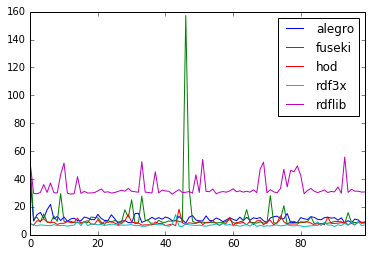

In [79]:
df_q0 = pd.DataFrame.from_records(data)
df_q0.plot()

In [80]:
df_q0.describe()

,alegro,fuseki,hod,rdf3x,rdflib
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,11.750254,12.594451,8.751934,7.074009,33.771265
std,3.615779,15.864267,1.763847,1.098858,6.591821
min,8.232178,7.492920,6.500000,5.715820,29.140137
25%,10.201111,8.668274,7.638062,6.518311,30.319824
50%,11.221436,9.071533,8.426025,6.835083,31.032349
75%,12.495667,10.303101,9.301453,7.283203,32.812256
max,40.856201,157.153809,18.402832,14.593994,55.696777


#### Query 1
We ignore fuseki for the time being because it takes FOREVER

In [101]:
# first get data for each query
## query1
R = {
    'hod': hod_query_1,
    'rdflib': rdflib_query_1,
    'rdf3x': rdf3x_query_1,
    'alegro': alegro_query_1,
}
data = {}
for name, func in R.items():
    print name
    data[name] = get_runs(func, 100)

alegro
hod
rdflib
rdf3x


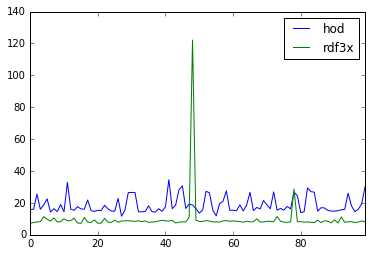

In [102]:
df_q1 = pd.DataFrame.from_records(data)
df_q1[['hod','rdf3x']].plot()

In [103]:
df_q1.describe()

,alegro,hod,rdf3x,rdflib
count,100.000000,100.000000,100.000000,100.000000
mean,1714.379646,18.665830,9.862627,11967.274585
std,22.556694,5.122650,11.558470,147.190327
min,1684.768066,11.681152,7.147217,11637.326172
25%,1699.531616,15.138062,7.999390,11876.560730
50%,1709.858398,16.333130,8.291992,11961.596436
75%,1722.078796,19.880066,8.776917,12077.251587
max,1808.288818,34.593018,122.168945,12369.259033


### Query 2

In [104]:
# first get data for each query
## query2
R = {
    'hod': hod_query_2,
    'rdflib': rdflib_query_2,
    'rdf3x': rdf3x_query_2,
    'alegro': alegro_query_2,
}
data = {}
for name, func in R.items():
    print name
    data[name] = get_runs(func, 100)

alegro
hod
rdflib
rdf3x


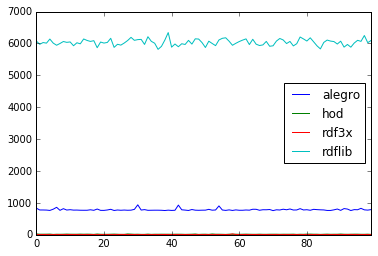

In [105]:
df_q2 = pd.DataFrame.from_records(data)
df_q2.plot()

In [106]:
df_q2.describe()

,alegro,hod,rdf3x,rdflib
count,100.000000,100.000000,100.000000,100.000000
mean,786.149702,17.533403,7.548213,6036.769246
std,30.452677,3.098643,2.456888,95.883228
min,758.904053,12.201172,6.065186,5816.015869
25%,769.608582,15.593323,6.632324,5973.151123
50%,777.875610,17.560547,7.156982,6034.368164
75%,789.544373,18.504700,7.517273,6099.054260
max,940.198975,28.770020,29.229736,6342.371826


### Query 3

In [107]:
# first get data for each query
## query3
R = {
    'hod': hod_query_3,
    'rdflib': rdflib_query_3,
    'rdf3x': rdf3x_query_3,
    'alegro': alegro_query_3,
}
data = {}
for name, func in R.items():
    print name
    data[name] = get_runs(func, 100)

alegro
hod
rdflib
rdf3x


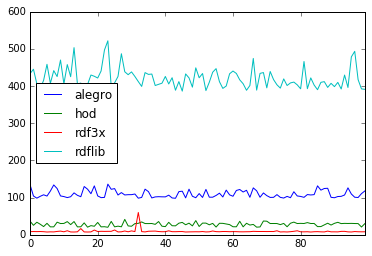

In [108]:
df_q3 = pd.DataFrame.from_records(data)
df_q3.plot()

In [109]:
df_q3.describe()

,alegro,hod,rdf3x,rdflib
count,100.000000,100.000000,100.000000,100.000000
mean,109.666213,28.348484,9.254336,421.214050
std,10.021782,5.071089,5.284033,27.618357
min,98.197021,20.241943,7.453857,386.238037
25%,101.075989,23.072449,8.016296,401.338501
50%,106.740479,30.204468,8.403076,413.494385
75%,117.309509,31.109375,8.997559,433.575867
max,136.212158,41.435059,59.972900,521.489746


hod
rdf3x


,hod,rdf3x
count,100.000000,100.000000
mean,31.707954,9.130366
std,7.539642,4.217573
min,21.716064,7.354980
25%,24.666138,8.117065
50%,33.484985,8.449829
75%,35.048584,8.959839
max,67.113037,48.890137


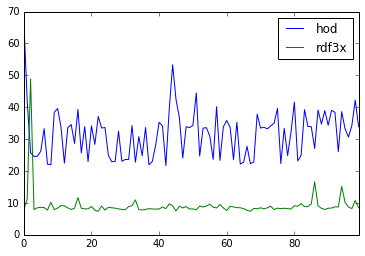

In [114]:
# first get data for each query
## query1
R = {
    'hod': hod_query_1_3x,
    'rdf3x': rdf3x_query_1,
}
data = {}
for name, func in R.items():
    print name
    data[name] = get_runs(func, 100)
df = pd.DataFrame.from_records(data)
df.plot()
df.describe()

Axes(0.125,0.125;0.775x0.775)


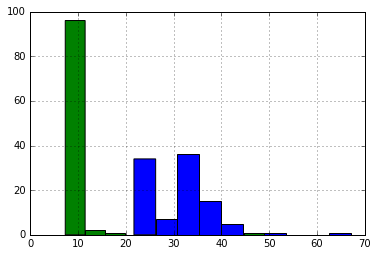

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111)
print ax
for col, vals in df.iteritems():
    vals.hist(ax=ax,bins=10)